*Tim Boudreau <br>
tim.boudreau25@gmail.com* <br>
https://github.com/timboudreau25/
***

# A Mile-High Impact on Baseball
### The effects of Coors Field

As a San Francisco Giants fan, I've spent quite a bit of time watching games in NL West ballparks. Anytime the Giants are in Colorado, I hear about the altitude and how it impacts the baseball. Using statistics and BaseballSavant data, I explored the impacts on pitch movement and batted balls from Coors Field. My hypothesis is that there is a significant and large influence on vertical pitch movement by the altitude.

In [14]:
%matplotlib inline

import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

## Data Source:

For this analysis, I used data from BaseballSavant (https://baseballsavant.mlb.com/about) and it's Statcast search tool. The data ranged from April 2017 through August 2017, for all players and pitches in the 2017 season through those dates.

## Data Acquisition:

### Database Formation:

Locally, I created the database separate from running my analysis, as the formation took a few minutes on my machine to run. Using a SQL database saved me quite a bit of time when I would run my analysis.

Due to limitations on query sizes through BaseballSavant, I could only export approximately 30,000 pitches per query, or about a week's worth of data. Before I formed my local database, I merged each week's data.

In [15]:
# ## current directory of data files

# cd = "/Data/"     # change if needed


# ## create empty dataframe

# data = pd.DataFrame()


# ## loop through each sheet and append the previous one

# for count in range(1, 23):
# 	import_data = pd.read_csv(cd + "savant_" 
# 		+ str(count) + ".csv")
# 	data = data.append(import_data)

    
# ## set any cells that say 'null' to numeric 123456789, and convert numeric columns to numeric

# data = data.replace(to_replace = 'null', value = "123456789").apply(pd.to_numeric, errors = "ignore")


## create/connect to database

path = 'Data/mlb_data.db'
conn = sqlite3.connect(path)
c = conn.cursor()


# add dataframe to database

# data.to_sql("MLB_2017", conn, if_exists="replace")

### SQL Query Into Database:

The variables of interest from my database were pitch characteristics and home team of the game each pitch was thrown in. The pitch characteristics I queried for are pitch type, release speed (in mph), release spin rate (in revolutions per minute), horizontal movement and vertical movement (both in inches). I used home team as a proxy for home field, as there has only been one series in which the home team wasn't in their home park: Houston during Hurricane Harvey.

In [16]:
## query for our data - home team, pitch type, and pitch characteristics

data = pd.read_sql("""SELECT home_team, pitcher, batter, pitch_type, release_speed, 
	release_spin_rate, pfx_x, pfx_z, bb_type, plate_x, plate_z, 
	launch_speed, launch_angle, hit_distance_sc
	FROM MLB_2017
	;""", conn)

c.close()			# close connection to db

## Data Preparation:

### Colorado Dummy:

To prepare for my regression, I had to organize and filer the data. I chose to create a dummy variable for Colorado, as the home park (with home team as a proxy) is a mile above sea level, to analyze the effect of altitude on pitch movement. I did write code to ask the user what team and therefor park to consider, but Colorado is the main focus of this assignment.

In [17]:
## ask for/define the home team, as proxy for home ballpark

teams = sorted(data['home_team'].unique().astype(str))


# ## ask for ballpark

# home_team = raw_input("\nPlease choose which of the following batted ball types"
# 	" to predict (ground_ball, line_drive, fly_ball, popup): ")

home_team = "COL"		# here, look at Colorado and park effects


## if input is not a team, clarify that error

if home_team not in teams:
	print("Your input was incorrect. Please match the spelling of an"
	" option from the following list.\n\n%s\n\nShutting down...\n\n" % teams)
	exit()


## create 0, 1 integer for home park

data['home'] = (data['home_team'] == home_team).astype(int)

### Data Organization

To more accurately analyze the effect of altitude, I created a subset to only include pitchers who have thrown in Colorado this season and a subset of batters who have batted in Colorado. I also created a list of pitches in this subset, to analyze the effect of altitude broken down by pitch type.

In [18]:
## remove null, listed as integer 123456789

data = data[(data != 123456789).all(1)]


## find list of pitchers who have thrown in colorado and elsewhere

names = data['pitcher'][data['home_team'] == home_team].unique()

data_sp = data[data['pitcher'].isin(names)]


## find list of batters who have hit in colorado and elsewhere

names = data['batter'][data['home_team'] == home_team].unique()

data_bat = data[data['batter'].isin(names)]


## gather list of pitches thrown, to analyze individually

pitches = data['pitch_type'].unique()


## define pitch movements from query to regress against

pitch_movement = ['pfx_x', 'pfx_z']

## Pitch Analysis:

To fully capture altitude's effect on pitches, I looped through each pitch type and both dimensions of pitch movement to have multiple unique regressions. I stored the coefficient on Colorado and it's p-values, to see the effects and significance levels.



In [19]:
## regress pitch characteristics on other characteristics and the above-park

home_coef = pd.DataFrame([])		# store values from regression loop

for pitch in pitches:


    data_reg = data_sp[['pitch_type', 'release_speed', 'release_spin_rate', 
                     'pfx_x', 'pfx_z', 'home']]
    
    data_reg = data_reg[data_reg['pitch_type'] == pitch]

    data_reg = data_reg.drop('pitch_type', axis = 1)


    for reg in pitch_movement:

        # print("\n##################\n%s\n##################" % reg)

        Y = data_reg[reg]
        X = data_reg.loc[:, data_reg.columns != reg]

        X = sm.add_constant(X)

        # corr = np.corrcoef(X)
        # print X

        results = sm.OLS(Y, X).fit()

        # print results.summary()

        # print results.params

        # if reg == "pfx_z":
        home_coef = home_coef.append(pd.DataFrame({ 'home coef' : results.params[4],
            'dep_var' : reg, 'p_value' : round(results.pvalues[4], 4),
            'pitch' : pitch}, index = [0]), ignore_index = True)

# home_coef = home_coef.sort_values(['dep_var', 'pitch'], ascending = True)
        
print home_coef

   dep_var  home coef  p_value pitch
0    pfx_x   0.918187   0.0000    FT
1    pfx_z  -0.116069   0.0000    FT
2    pfx_x   0.305960   0.0000    FF
3    pfx_z  -0.178694   0.0000    FF
4    pfx_x   0.232219   0.0000    CU
5    pfx_z   0.213968   0.0000    CU
6    pfx_x   0.549040   0.0000    CH
7    pfx_z   0.034984   0.1495    CH
8    pfx_x   0.186175   0.0000    SL
9    pfx_z  -0.005744   0.7103    SL
10   pfx_x   0.604652   0.0000    SI
11   pfx_z  -0.115221   0.0000    SI
12   pfx_x  -0.017107   0.4263    FC
13   pfx_z  -0.067381   0.0126    FC
14   pfx_x   0.271659   0.1804    FS
15   pfx_z   0.230278   0.0382    FS
16   pfx_x   0.241194   0.0021    KC
17   pfx_z   0.256224   0.0002    KC


### Pitch Results:

No pitch was significantly effected by altitude by an inch or more. I found this to be suspicious - further thought and exploration is needed.

Sinkers, changeups, four seam fastballs, sliders, two seam fastballs and cutters all had statistically significant impacts (to the 99% confidence level) on both horizontal and vertical movement. Curveballs and knuckle curves had no significant impact on movement, which was also suspicious.
Splitters had statistically significant horizontal movement effects, at the 90% confidence level.

All statistically significant effects by altitude on movement were in the same directions - glove-side for horizontal movement and downward for vertical movement.

## Batting Analysis:

My batting analysis is more exploratory than predictive, to validate my skepticism of the results of my pitching analysis. I decided to analyze batted ball characteristics, namely launch speed, launch angle and batted ball distribution.

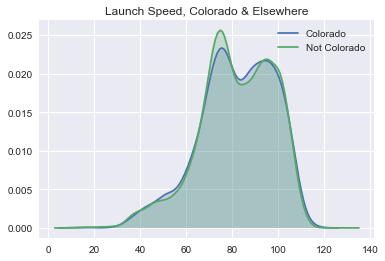

In [20]:
## plot frequency plots for exit velocity in Colorado and everywhere else

sns.kdeplot(data_bat['launch_speed'][data_bat['home'] == 1], shade = True, label = "Colorado")
sns.kdeplot(data_bat['launch_speed'][data_bat['home'] != 1], shade = True, label = "Not Colorado")
plt.legend()
plt.title("Launch Speed, Colorado & Elsewhere")
plt.show()

As seen above, the shape of exit velocity distributions are similar both in Colorado and out. In Colorado, however, There are fewer balls hit around 70-80 mph and more hit between about 85-95 mph. As exit velocity is measured off the bat, this would have to be influenced by changes in pitch characteristics - or batters swinging differently.

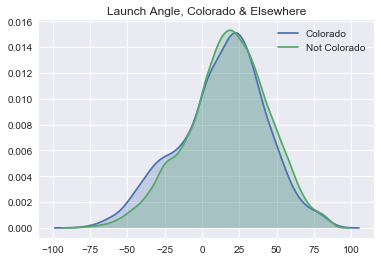

In [21]:
## plot frequency plots for launch angle in Colorado and everywhere else

sns.kdeplot(data_bat['launch_angle'][data_bat['home'] == 1], shade = True, label = "Colorado")
sns.kdeplot(data_bat['launch_angle'][data_bat['home'] != 1], shade = True, label = "Not Colorado")
plt.legend()
plt.title("Launch Angle, Colorado & Elsewhere")

The launch angle distributions for in Colorado and outside Colorado are similar, as before. However, batters in Colorado hit more ground balls (in the -70 to -20 degree launch angle zone) and fewer fly balls (in the 5 to 40 degree launch angle zone). This is likely due to changes in pitch selection or zones pitched to by pitchers, but could also be a failed attempt by batters to elevate the ball more at altitude.

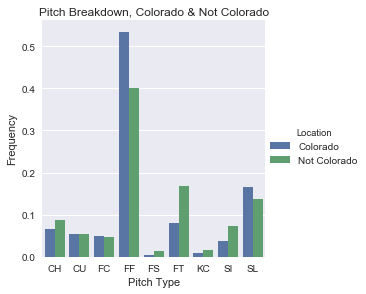

In [22]:
## Gather pitch type data and format the data properly

pitch_list = pd.crosstab(data_sp.pitch_type, data_sp.home)
pitch_list.columns = ["Not Colorado", "Colorado"]

pitch_dist = pitch_list
pitch_dist = pitch_dist.drop(['Colorado', 'Not Colorado'], axis = 1)


## find the percentage of pitches that each pitch type is and format the data

pitch_dist['Colorado'] = pitch_list['Colorado'] / sum(pitch_list['Colorado'])
pitch_dist['Not Colorado'] = pitch_list['Not Colorado'] / sum(pitch_list['Not Colorado'])
pitch_dist['Pitch Type'] = pitch_dist.index

pitch_dist_plot = pd.melt(pitch_dist, id_vars="Pitch Type", var_name = "Location"
	, value_name = "Frequency")


## plot!

sns.factorplot(x = 'Pitch Type', y = 'Frequency', hue = 'Location', 
	data = pitch_dist_plot, kind = 'bar')

plt.title("Pitch Breakdown, Colorado & Not Colorado")

There are two things I constantly hear about pitching in Colorado: one, breaking balls are aversly affected by altitude and two, use fastballs because of number one. These points both can be seen here, with a large increase in four seam usage and decreases in many breaking pitches, such as curves and breaking fastballs. 

  Batted Ball Type      Location  Frequency
0         fly_ball      Colorado   0.219968
1      ground_ball      Colorado   0.468463
2       line_drive      Colorado   0.281458
3            popup      Colorado   0.030111
4         fly_ball  Not Colorado   0.245695
5      ground_ball  Not Colorado   0.424341
6       line_drive  Not Colorado   0.279687
7            popup  Not Colorado   0.050277


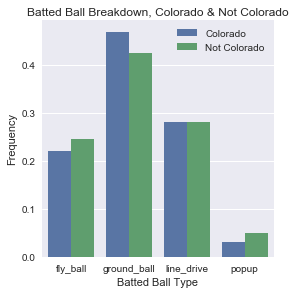

In [ ]:
## remove all null string data in batted balls (earlier listed as 123456789)

data_bat = data_bat[data_bat['bb_type'] != "123456789"]


## Gather batted ball data and format the data properly

batted_balls = pd.crosstab(data_bat.bb_type, data_bat.home)
batted_balls.columns = ['Not Colorado', 'Colorado']

batted_balls_dist = batted_balls
batted_balls_dist = batted_balls_dist.drop(['Colorado', 'Not Colorado'], axis = 1)


## find the percentage of batted balls that each batted ball type is and format the data

batted_balls_dist['Colorado'] = batted_balls['Colorado'] / sum(batted_balls['Colorado'])
batted_balls_dist['Not Colorado'] = batted_balls['Not Colorado'] / sum(batted_balls['Not Colorado'])
batted_balls_dist['Batted Ball Type'] = batted_balls_dist.index

batted_balls_plot = pd.melt(batted_balls_dist, id_vars="Batted Ball Type", var_name = "Location"
	, value_name = "Frequency")

print batted_balls_plot

## plot!

sns.factorplot(x = 'Batted Ball Type', y = 'Frequency', hue = 'Location', 
	data = batted_balls_plot, kind = 'bar', legend = False)

plt.title("Batted Ball Breakdown, Colorado & Not Colorado")
plt.legend(loc = 'upper right')

Whether a result of the changed pitch distribution, pitch location or batter approach, there is a noticable change in the batted ball distribution in Colorado versus elsewhere. There are fewer fly balls and pop ups and, to offset that, an increased amount of fly balls. There isn't much change in line drive rates, which is expected, as it is generally accepted that line drives, from a pitcher's perspective, appear as random occurances and aren't controllable.

In [ ]:
## clear any null data (previously converted into 123456789 integers)

data_zone = data[data['plate_x'] != 123456789][data['plate_z'] != 123456789]


## prepare a plot with subplots

sns.set(style="darkgrid")
f, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
f.suptitle("Pitch Heat Maps, Pitcher's View")
plt.xlim(-1.5, 1.5)
plt.ylim(1, 4)


## plot pitch locations in heatmaps for in Colorado and elsewhere

ax1.set_title("Not Colorado")
sns.kdeplot(data_zone['plate_x'][data['home'] != 1], data_zone['plate_z'][data['home'] != 1], 
            cmap = "Reds", shade = True, shade_lowest = False, ax = ax1)

ax2.set_title("Colorado")
sns.kdeplot(data_zone['plate_x'][data['home'] == 1], data_zone['plate_z'][data['home'] == 1], 
            cmap = "Blues", shade = True, shade_lowest = False, ax = ax2)

These heat maps of pitch locations are from the catcher's view, with (0, 2.5 feet) as the center of the plate. They may take a minute or two to load.

Pitchers in Colorado seems to favor two locations, neither of which is where the rest of the league dominantl pitches. The first is over the left side of the plate, which is away from lefties and inside to righties. The second is up and in to lefties. My theory as to why these are the focal points of pitch locating in Colorad is that right field is where batted balls could cause the most damage, as the Rockies heightened the right-center field wall. Pitchers are trying to either have the ball hit to left field or weakly to right field. In another analysis, I may revist this idea and explore where in certain ballparks batted balls are most damaging. 

## Problems & Issues

One problem I had was the result of what I assume to be incomplete modeling. I expected and still assume that altitude has a larger impact on pitches, specificaly breaking pitches, than what my model suggests. To fix this, I would need to search for different variables in this or other datasets, while considering different models as well, as the issue could be the model itself. 

Another problem I encountered was multicollinearity within my model. Many of the regressions ran had multicollinearity issues. Below is my calculation for the condition number of this model. A condition number of a function or model describes how much the dependent variable can change with a small change in the independent variables - a larger condition number implies an error in input variable measure will greatly increase the error in output variable. The condition number is extremely large, which heavily implies multicollinearity is an issue. It may be best to accept there is multicollinearity, likely through an instrumental variable I failed to account for. I will try to revisit this another day.

An issue I had with this project was, in my opinion, the lack of structure in my plan to attack my hypothesis. There is enough data to make one's head spin! I chose to browse what I deemed were interesting or important details, but felt I left many out while at the same time not having a flow between pieces.

In [ ]:
## source for this code: http://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

## 
norm_x = X.values
for i, name in enumerate(X):
    if name == "const":            ## skip the constant from the model
        continue
    norm_x[:,i] = X[name]/np.linalg.norm(X[name])    ## normalize values
norm_xtx = np.dot(norm_x.T,norm_x)

eigs = np.linalg.eigvals(norm_xtx)                   ## collect eigenvalues from normalized data
condition_number = np.sqrt(eigs.max() / eigs.min())  ## calculate condition number

print "\nCondition number: ", (condition_number)

## Conclusion

Altitude significantly affects pitches. This has been known by players, coaches and fans since Colorado received a Major League team. Batters hit the ball harder and higher (as well as lower) than elsewhere, likely to try to take advantage of the thinner atmosphere and further carry. Pitchers recognize these conditions and throw different pitches, in different locations, to prevent this. The distribution of batted balls in Colorado, compared to other stadiums, reflects this - there is a decrease in fly balls and increase in ground balls despite batters hitting the ball harder and likely trying to lift the ball. With strike-zone data, such as bat path and speed, I could explore that further.

I was able to somewhat verify my hypothesis - many pitch types have a significant impact on vertical movement by altitude. Surprisingly, though, my model suggested altitude doesn't impact the most drastic breaking pitches, curveballs. I'm skeptical of these results, and need to further explore this.

### Next Steps:

- Work on my model to better accurately analyze the data.
- Gather more data to include in the model that could be missing and impacting my results.
- Search for data on bat angle and speed to statistically see if there is a change in approach by batters, or batters of certain types.